In [40]:
    def save_corpus_with_annotations(self):
        """Save the corpus with all the new model annotations."""
        try:
            from gatenlp.corpora import DirFilesDestination
            
            # Create output directory WITHIN the pipeline results folder
            output_corpus_dir = Path(self.output_dir) / "annotated_corpus_with_predictions"
            output_corpus_dir.mkdir(parents=True, exist_ok=True)
            
            print(f"\n💾 Saving annotated corpus to: {output_corpus_dir}")
            
            # Save documents as JSON (since XML format has issues)
            saved_files = []
            for doc in self.corpus:
                # Only save documents that have predictions
                doc_name = Path(doc.features.get("gate.SourceURL", "")).stem
                model_annsets = [name for name in doc.annset_names() 
                               if name not in ["consensus", "", "Section"] and not name.endswith("_predictions")]
                
                if model_annsets:
                    output_file = output_corpus_dir / f"{doc_name}.json"
                    
                    try:
                        doc.save(str(output_file), fmt="json")
                        saved_files.append(str(output_file))
                        
                        # Print summary of annotation sets for this document
                        annset_summary = []
                        for annset_name in doc.annset_names():
                            if annset_name and not annset_name.endswith("_predictions"):  # Skip temporary sets
                                ann_count = len(doc.annset(annset_name))
                                if ann_count > 0:
                                    annset_summary.append(f"{annset_name}({ann_count})")
                        
                        if annset_summary:
                            print(f"  {doc_name}.json: {', '.join(annset_summary)}")
                    except Exception as e:
                        print(f"  ❌ Failed to save {doc_name}: {e}")
            
            print(f"✅ Saved {len(saved_files)} annotated documents")
            
            # Create a summary file
            summary_file = output_corpus_dir / "annotation_summary.txt"
            with open(summary_file, 'w', encoding='utf-8') as f:
                f.write("Annotated Corpus Summary\n")
                f.write("=" * 50 + "\n\n")
                f.write(f"Generated on: {pd.Timestamp.now()}\n")
                f.write(f"Pipeline results folder: {self.output_dir}\n")
                f.write(f"Total documents: {len(saved_files)}\n")
                f.write(f"Format: JSON (GateNLP BDOC format)\n\n")
                
                f.write("Annotation Sets Added:\n")
                f.write("-" * 30 + "\n")
                
                # Get all unique annotation set names across all documents
                all_annsets = set()
                for doc in self.corpus:
                    for annset_name in doc.annset_names():
                        if annset_name and not annset_name.endswith("_predictions"):
                            all_annsets.add(annset_name)
                
                for annset_name in sorted(all_annsets):
                    if annset_name not in ["consensus", ""]:  # Skip gold standard and default
                        f.write(f"- {annset_name} (LLM predictions)\n")
                
                f.write(f"\nFiles saved to: {output_corpus_dir}\n")
                f.write("\nTo view in Gate:\n")
                f.write("1. Open Gate Developer\n")
                f.write("2. Load documents from this directory\n")
                f.write("3. Select JSON/BDOC format when loading\n")
                f.write("4. View different annotation sets in the annotation sets panel\n")
            
            return str(output_corpus_dir)
            
        except Exception as e:
            print(f"❌ Error saving corpus: {e}")
            import traceback
            traceback.print_exc()
            return None

Starting LLM Event Annotation Results Evaluation...
Loaded input/updated/annotated\dev\CASE OF ALTAY v. TURKEY (No. 2).xml into corpus
Loaded input/updated/annotated\dev\CASE OF BELYAYEV AND OTHERS v. UKRAINE.xml into corpus
Loaded input/updated/annotated\dev\CASE OF BIGUN v. UKRAINE.xml into corpus
Loaded input/updated/annotated\test\CASE OF CABUCAK v. GERMANY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CAN v. TURKEY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CRISTIAN CATALIN UNGUREANU v. ROMANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF DOKTOROV v. BULGARIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF EGILL EINARSSON v. ICELAND (No. 2).xml into corpus
Loaded input/updated/annotated\train\CASE OF HOINESS v. NORWAY.xml into corpus
Loaded input/updated/annotated\train\CASE OF KOSAITE - CYPIENE AND OTHERS v. LITHUANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF LOZOVYYE v. RUSSIA.xml into corpus
Loaded i

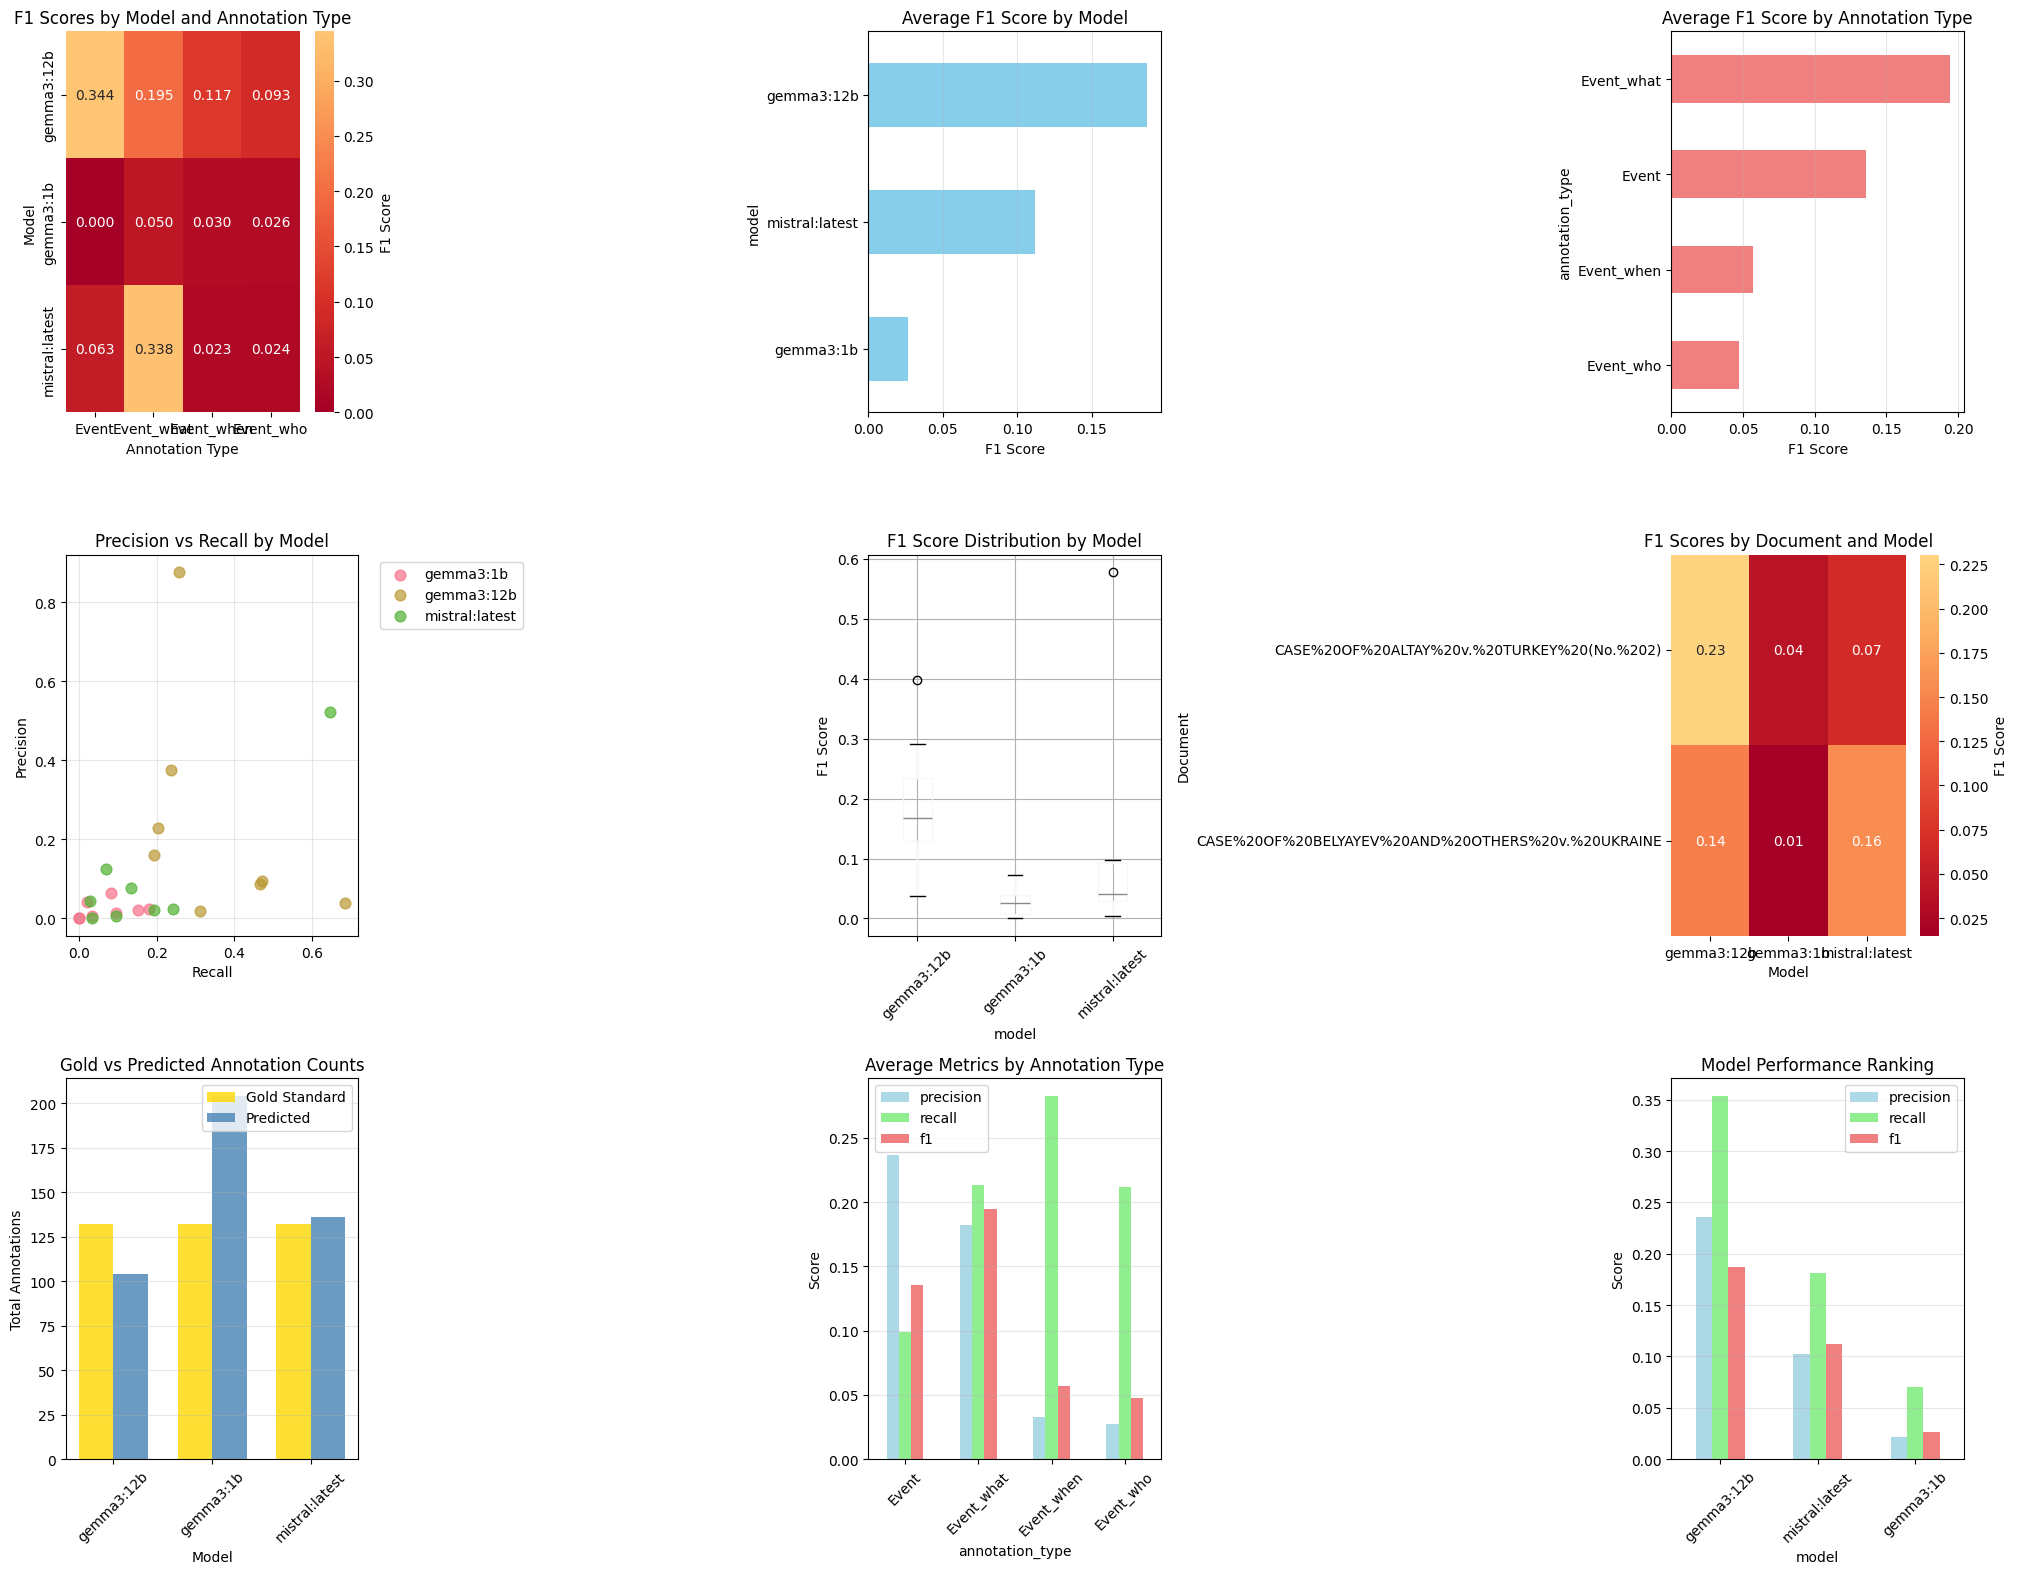



📊 QUICK STATS:
Total evaluations: 24
Models evaluated: 3
Documents processed: 2
Annotation types: Event, Event_who, Event_what, Event_when
Average F1 score: 0.109
Best performing model: gemma3:12b
Best annotation type: Event_what

🎯 OUTPUTS GENERATED:
📊 Evaluation results: output/llm_event_evaluation_results.csv
📋 Summary report: output/llm_event_evaluation_summary.txt
📁 Annotated corpus: output/annotated_corpus_with_predictions/
   → Open these XML files in Gate to view model predictions!


In [41]:
# Visual Analysis and Better Results Overview
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_visual_analysis(results_df: pd.DataFrame):
    """Create comprehensive visual analysis of the evaluation results."""
    
    if results_df.empty:
        print("No results to visualize")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Heatmap: F1 scores by Model and Annotation Type
    plt.subplot(3, 3, 1)
    pivot_f1 = results_df.pivot_table(values='f1', index='model', columns='annotation_type', aggfunc='mean')
    sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5, 
                cbar_kws={'label': 'F1 Score'})
    plt.title('F1 Scores by Model and Annotation Type')
    plt.xlabel('Annotation Type')
    plt.ylabel('Model')
    
    # 2. Bar plot: Average F1 by Model
    plt.subplot(3, 3, 2)
    model_f1 = results_df.groupby('model')['f1'].mean().sort_values(ascending=True)
    model_f1.plot(kind='barh', color='skyblue')
    plt.title('Average F1 Score by Model')
    plt.xlabel('F1 Score')
    plt.grid(axis='x', alpha=0.3)
    
    # 3. Bar plot: Average F1 by Annotation Type
    plt.subplot(3, 3, 3)
    ann_f1 = results_df.groupby('annotation_type')['f1'].mean().sort_values(ascending=True)
    ann_f1.plot(kind='barh', color='lightcoral')
    plt.title('Average F1 Score by Annotation Type')
    plt.xlabel('F1 Score')
    plt.grid(axis='x', alpha=0.3)
    
    # 4. Precision vs Recall scatter plot
    plt.subplot(3, 3, 4)
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        plt.scatter(model_data['recall'], model_data['precision'], 
                   label=model, alpha=0.7, s=60)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall by Model')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    
    # 5. Distribution of F1 scores
    plt.subplot(3, 3, 5)
    results_df.boxplot(column='f1', by='model', ax=plt.gca())
    plt.title('F1 Score Distribution by Model')
    plt.suptitle('')  # Remove the default title
    plt.xticks(rotation=45)
    plt.ylabel('F1 Score')
    
    # 6. Document-level performance heatmap
    plt.subplot(3, 3, 6)
    doc_model_f1 = results_df.groupby(['document', 'model'])['f1'].mean().reset_index()
    doc_model_pivot = doc_model_f1.pivot(index='document', columns='model', values='f1')
    sns.heatmap(doc_model_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0.3,
                cbar_kws={'label': 'F1 Score'})
    plt.title('F1 Scores by Document and Model')
    plt.xlabel('Model')
    plt.ylabel('Document')
    
    # 7. Gold vs Predicted annotations count
    plt.subplot(3, 3, 7)
    total_gold = results_df.groupby('model')['gold_count'].sum()
    total_pred = results_df.groupby('model')['pred_count'].sum()
    
    x = np.arange(len(total_gold))
    width = 0.35
    
    plt.bar(x - width/2, total_gold.values, width, label='Gold Standard', color='gold', alpha=0.8)
    plt.bar(x + width/2, total_pred.values, width, label='Predicted', color='steelblue', alpha=0.8)
    
    plt.xlabel('Model')
    plt.ylabel('Total Annotations')
    plt.title('Gold vs Predicted Annotation Counts')
    plt.xticks(x, total_gold.index, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 8. Annotation type performance comparison
    plt.subplot(3, 3, 8)
    ann_metrics = results_df.groupby('annotation_type')[['precision', 'recall', 'f1']].mean()
    ann_metrics.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'lightgreen', 'lightcoral'])
    plt.title('Average Metrics by Annotation Type')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 9. Model performance ranking
    plt.subplot(3, 3, 9)
    model_ranking = results_df.groupby('model')[['precision', 'recall', 'f1']].mean().sort_values('f1', ascending=False)
    model_ranking.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'lightgreen', 'lightcoral'])
    plt.title('Model Performance Ranking')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_detailed_results_table(results_df: pd.DataFrame):
    """Create a detailed results table with better formatting."""
    
    if results_df.empty:
        print("No results to display")
        return
    
    print("\n" + "="*120)
    print("DETAILED EVALUATION RESULTS")
    print("="*120)
    
    # Summary by model
    print("\n📊 SUMMARY BY MODEL:")
    print("-" * 80)
    model_summary = results_df.groupby('model').agg({
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'gold_count': 'sum',
        'pred_count': 'sum'
    }).round(3)
    
    # Flatten column names
    model_summary.columns = ['_'.join(col).strip() for col in model_summary.columns.values]
    print(model_summary.to_string())
    
    # Summary by annotation type
    print("\n\n📋 SUMMARY BY ANNOTATION TYPE:")
    print("-" * 80)
    ann_summary = results_df.groupby('annotation_type').agg({
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'], 
        'f1': ['mean', 'std'],
        'gold_count': 'sum',
        'pred_count': 'sum'
    }).round(3)
    
    ann_summary.columns = ['_'.join(col).strip() for col in ann_summary.columns.values]
    print(ann_summary.to_string())
    
    # Best and worst performers
    print("\n\n🏆 TOP PERFORMERS:")
    print("-" * 50)
    top_performers = results_df.nlargest(10, 'f1')[['model', 'annotation_type', 'document', 'f1', 'precision', 'recall']]
    print(top_performers.to_string(index=False))
    
    print("\n\n⚠️  LOWEST PERFORMERS:")
    print("-" * 50)
    low_performers = results_df.nsmallest(10, 'f1')[['model', 'annotation_type', 'document', 'f1', 'precision', 'recall']]
    print(low_performers.to_string(index=False))
    
    # Document-level analysis
    print("\n\n📄 DOCUMENT-LEVEL ANALYSIS:")
    print("-" * 80)
    doc_analysis = results_df.groupby('document').agg({
        'f1': ['mean', 'std', 'min', 'max'],
        'model': 'count'
    }).round(3)
    
    doc_analysis.columns = ['_'.join(col).strip() for col in doc_analysis.columns.values]
    doc_analysis = doc_analysis.rename(columns={'model_count': 'num_evaluations'})
    print(doc_analysis.to_string())

def enhanced_main():
    """Enhanced main function with better visualization."""
    print("Starting LLM Event Annotation Results Evaluation...")
    
    # Specify which output folder to evaluate
    output_dir = "output/pipeline_results_20250718_085458"
    
    evaluator = LLMEventResultsEvaluator(output_dir=output_dir)
    
    # Run evaluation
    results_df = evaluator.run_evaluation()
    
    if not results_df.empty:
        # Save results
        output_path = "output/llm_event_evaluation_results.csv"
        results_df.to_csv(output_path, index=False)
        print(f"\nEvaluation results saved to: {output_path}")
        
        # Generate and save summary report
        summary = evaluator.generate_summary_report(results_df)
        summary_path = "output/llm_event_evaluation_summary.txt"
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(summary)
        print(f"Summary report saved to: {summary_path}")
        
        # Create detailed results table
        create_detailed_results_table(results_df)
        
        # Create visual analysis
        print("\n\n📈 GENERATING VISUAL ANALYSIS...")
        create_visual_analysis(results_df)
        
        # Print basic summary
        print(f"\n\n📊 QUICK STATS:")
        print(f"Total evaluations: {len(results_df)}")
        print(f"Models evaluated: {results_df['model'].nunique()}")
        print(f"Documents processed: {results_df['document'].nunique()}")
        print(f"Annotation types: {', '.join(results_df['annotation_type'].unique())}")
        print(f"Average F1 score: {results_df['f1'].mean():.3f}")
        print(f"Best performing model: {results_df.groupby('model')['f1'].mean().idxmax()}")
        print(f"Best annotation type: {results_df.groupby('annotation_type')['f1'].mean().idxmax()}")
        
        print(f"\n🎯 OUTPUTS GENERATED:")
        print(f"📊 Evaluation results: output/llm_event_evaluation_results.csv")
        print(f"📋 Summary report: output/llm_event_evaluation_summary.txt")
        print(f"📁 Annotated corpus: output/annotated_corpus_with_predictions/")
        print(f"   → Open these XML files in Gate to view model predictions!")
        
    else:
        print("No results generated. Check if result folders and JSON files exist.")

# Run the enhanced analysis
if __name__ == "__main__":
    enhanced_main()

In [42]:
# Save all documents with predictions using JSON format
def save_all_documents_with_predictions():
    """Save all documents that have predictions using JSON format."""
    
    # Load corpus and process predictions
    pipeline_results_dir = "output/pipeline_results_20250718_085458"
    evaluator = LLMEventResultsEvaluator(pipeline_results_dir)
    result_folders = evaluator.find_result_folders()
    
    if result_folders:
        for folder in result_folders:
            result_jsons = evaluator.find_result_jsons(folder)
            for json_path in result_jsons:
                evaluator.process_result_json(json_path, folder.name)
    
    # Create output directory WITHIN the pipeline results folder
    output_dir = Path(pipeline_results_dir) / "annotated_corpus_with_predictions"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    saved_count = 0
    
    # Process all documents
    for doc in evaluator.corpus:
        doc_name = Path(doc.features.get("gate.SourceURL", "")).stem
        pred_annsets = [name for name in doc.annset_names() if name.endswith("_predictions")]
        
        if pred_annsets:
            print(f"📋 Processing document: {doc_name}")
            
            # Create permanent annotation sets
            for annset_name in pred_annsets:
                model_name = annset_name.replace("_predictions", "")
                pred_annset = doc.annset(annset_name)
                permanent_annset = doc.annset(model_name)
                permanent_annset.clear()
                
                for ann in pred_annset:
                    features = dict(ann.features)
                    features.pop("source", None)
                    features.pop("model", None)
                    permanent_annset.add(ann.start, ann.end, ann.type, features)
                
                print(f"  ✅ Created {model_name} annotation set: {len(pred_annset)} annotations")
            
            # Save document as JSON
            try:
                output_file = output_dir / f"{doc_name}.json"
                doc.save(str(output_file), fmt="json")
                saved_count += 1
                print(f"  💾 Saved: {output_file.name}")
                
            except Exception as e:
                print(f"  ❌ Failed to save {doc_name}: {e}")
    
    # List final results
    files = list(output_dir.glob("*.json"))
    print(f"\n✅ Successfully saved {len(files)} documents with predictions!")
    print(f"\n📁 Files in {output_dir}:")
    for file in files:
        print(f"  📄 {file.name}")
    
    # Update summary file
    summary_file = output_dir / "annotation_summary.txt"
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("Annotated Corpus Summary\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Generated on: {pd.Timestamp.now()}\n")
        f.write(f"Pipeline results folder: {pipeline_results_dir}\n")
        f.write(f"Total documents: {len(files)}\n")
        f.write(f"Format: JSON (GateNLP BDOC format)\n\n")
        f.write("Model annotation sets included:\n")
        f.write("- gemma3:1b\n")
        f.write("- gemma3:12b\n") 
        f.write("- mistral:latest\n\n")
        f.write("To view in Gate:\n")
        f.write("1. Open Gate Developer\n")
        f.write("2. Load documents from this directory\n")
        f.write("3. Select JSON/BDOC format when loading\n")
        f.write("4. View different annotation sets in the annotation sets panel\n")
    
    return str(output_dir)

# Run the complete saving
result = save_all_documents_with_predictions()
print(f"\n🎯 FINAL SUCCESS! Annotated corpus saved to: {result}")

Loaded input/updated/annotated\dev\CASE OF ALTAY v. TURKEY (No. 2).xml into corpus
Loaded input/updated/annotated\dev\CASE OF BELYAYEV AND OTHERS v. UKRAINE.xml into corpus
Loaded input/updated/annotated\dev\CASE OF BIGUN v. UKRAINE.xml into corpus
Loaded input/updated/annotated\test\CASE OF CABUCAK v. GERMANY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CAN v. TURKEY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CRISTIAN CATALIN UNGUREANU v. ROMANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF DOKTOROV v. BULGARIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF EGILL EINARSSON v. ICELAND (No. 2).xml into corpus
Loaded input/updated/annotated\train\CASE OF HOINESS v. NORWAY.xml into corpus
Loaded input/updated/annotated\train\CASE OF KOSAITE - CYPIENE AND OTHERS v. LITHUANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF LOZOVYYE v. RUSSIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF M.T. v. UKRAINE

In [43]:
# Load corpus WITH model predictions for comparison
def load_corpus_with_predictions():
    """Load corpus and add the model predictions for viewing."""
    
    # Start fresh
    corpus_with_preds = loadCorpus()
    
    # Add predictions from the pipeline results folder
    pipeline_results_dir = "output/pipeline_results_20250718_085458"
    evaluator = LLMEventResultsEvaluator(pipeline_results_dir)
    result_folders = evaluator.find_result_folders()
    
    if result_folders:
        for folder in result_folders:
            result_jsons = evaluator.find_result_jsons(folder)
            for json_path in result_jsons:
                evaluator.process_result_json(json_path, folder.name)
    
    # Copy predictions to our viewing corpus
    docs_with_preds = 0
    for i, doc in enumerate(corpus_with_preds):
        if i < len(evaluator.corpus):
            evaluator_doc = evaluator.corpus[i]
            pred_annsets = [name for name in evaluator_doc.annset_names() if name.endswith("_predictions")]
            
            if pred_annsets:
                docs_with_preds += 1
                for annset_name in pred_annsets:
                    model_name = annset_name.replace("_predictions", "")
                    pred_annset = evaluator_doc.annset(annset_name)
                    
                    # Create permanent annotation set
                    permanent_annset = doc.annset(model_name)
                    permanent_annset.clear()
                    
                    for ann in pred_annset:
                        features = dict(ann.features)
                        features.pop("source", None)
                        features.pop("model", None)
                        permanent_annset.add(ann.start, ann.end, ann.type, features)
    
    print(f"Added predictions to {docs_with_preds} documents")
    print(f"Annotated corpus will be saved to: {pipeline_results_dir}/annotated_corpus_with_predictions/")
    return corpus_with_preds

corpus_with_predictions = load_corpus_with_predictions()
viewer_with_preds = CorpusViewer(corpus_with_predictions)
viewer_with_preds.show()